[Tensorbard로 모델, 데이터, 학습 시각화](https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html)

`torchvision.datasets` 의 Fashion-MNIST dataset으로 코드 진행

학습 목적
1. 데이터 읽고 변환
2. Tensorboard 설정
3. Tensorboard 기록
4. Tensorboard 이용해서 모델 구조 살펴보기
5. 코드 추가 $→$ 시각화의 대화식 버전 만들기
    
    - 학습 데이터를 검사하는 방법
    - 학습에 따른 모델의 성능을 추적하는 방법
    - 학습이 완료된 모델의 성능을 평가하는 방법


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

# datasets
trainset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform
)

# dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

# 분류 결과를 위한 상수
classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot',
)

# 이미지를 보여주기 위한 헬퍼 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)

    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [3]:
# optimizer, criterion 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1. TensorBoard 설정

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

### 2. TensorBoard에 기록하기

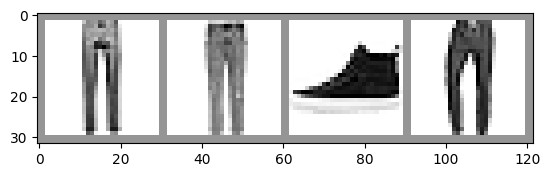

In [5]:
# make_grid 를 사용해서 grid 사용

dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 그리드 생성
img_grid = torchvision.utils.make_grid(images)

# 이미지 보여주기
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록
writer.add_image('four_fashion_mnist_images', img_grid)

In [16]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### 3. TensorBoard 를 사용해서 모델 살펴보기

In [9]:
writer.add_graph(net, images)
writer.close()

### 4. TensorBoard에 \<Projector> 추가하기

In [14]:
# add_embedding 메소드를 통해 고차원 데이터의 저차원 표현을 시각화 가능

# 헬퍼 함수
def select_n_random(data, labels, n=100):
    """데이터셋에서 n개 임의의 데이터와 그에 해당하는 라벨을 선택 가능
    """
    assert len(data) == len(labels)
    
    # return a random permutation of integers from 0 to len(data)-1
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 임의의 이미지들과 정답 인덱스 선택
images, labels = select_n_random(trainset.data, trainset.targets)

# 각 이미지의 분류 라벨 가져오기
class_labels = [classes[lab] for lab in labels]

# 임베딩 내역 기록
features = images.view(-1, 28 * 28)
writer.add_embedding(
    features,
    metadata=class_labels,
    label_img=images.unsqueeze(1)
)

writer.close()

### 5. TensorBoard로 모델 학습 추적하기

`plot_classes_preds` 함수를 이용해서 예측 결과를 함께 보기

In [23]:
# 헬퍼 함수

def images_to_probs(net, images):
    """학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률 생성
    """
    output = net(images)
    
    # 출력 확률을 변환
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    """
    학습된 신경망 + 배치로부터 가져온 이미지와 라벨 이용해서 matplotlib figure 생성
    신경망의 예측 결과, 확률과 함께 정답을 보여주며, 결과가 맞았는지 여부에 따라 색을 다르게 표시
    `images_to_probs` 함수를 사용
    """
    preds, probs = images_to_probs(net, images)
    
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
                classes[preds[idx]],
                probs[idx] * 100.0,
                classes[labels[idx]]
            ),
            color=("green" if preds[idx]==labels[idx].item() else "red")
        )
    return fig

1000배치마다 콘솔에 출력하는 대신\
TensorBoard에 결과를 기록하며 학습\
`add_scalar` 함수를 사용

또한, 학습을 하며 배치에 포함된 이미지에 대한 모델 예측 결과와\
정답을 비교하여 보여주는 이미지도 생성

In [ ]:
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            writer.add_scalar('training loss',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
        
        # 무작위 미니배치에 대한 예측 결과 보여주기 위함
        writer.add_figure('predictions vs actuals',
                          plot_classes_preds(net, inputs, labels),
                          global_step=epoch * len(trainloader) + i)
        running_loss = 0.0
print('Finished Training')

### 6. TensorBoard로 학습된 모델 평가하기

In [26]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옴
# 2. 예측 결과를 test_size 텐서로 가져옴

class_probs = []
class_label = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        
        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    """`class_index` 가져온 뒤 precision-recall 곡선 그리기
    """
    
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(
        classes[class_index],
        tensorboard_truth,
        tensorboard_probs,
        global_step=global_step
    )
    writer.close()
    
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)